In [24]:
%load_ext autoreload
%autoreload 2
from imodelsx import TreePromptClassifier
import datasets
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# set up data
rng = np.random.default_rng(seed=42)
dset_train = datasets.load_dataset('rotten_tomatoes')['train']
dset_train = dset_train.select(rng.choice(
    len(dset_train), size=100, replace=False))
dset_val = datasets.load_dataset('rotten_tomatoes')['validation']
dset_val = dset_val.select(rng.choice(
    len(dset_val), size=100, replace=False))

# set up arguments
# template for the prompt, for different prompt styles (e.g. few-shot), may want to place {prompt} before {example}
# or you may want to add some text before the verbalizer, e.g. {example}{prompt} Output:
prompt_template = "{example}{prompt}"
prompts = [
    " This movie is",
    " Positive or Negative? The movie was",
    " The sentiment of the movie was",
    " The plot of the movie was really",
    " The acting in the movie was",
]
verbalizer = {0: " Negative.", 1: " Positive."}
checkpoint = "gpt2"

# extract prompt outputs and fit decision tree of prompts
m = TreePromptClassifier(
    checkpoint=checkpoint,
    prompts=prompts,
    verbalizer=verbalizer,
    prompt_template=prompt_template,
    # cache_prompt_features_dir='cached_prompt_features',
    # cache_key_values=False,
)
m.fit(dset_train["text"], dset_train["label"])


# compute accuracy
print('Predicting on validation set...')
preds = m.predict(dset_val['text'])
print('\nTree-Prompt acc (val) ->',
      np.mean(preds == dset_val['label']))

# compare to accuracy for individual prompts
for i, prompt in enumerate(prompts):
    print(i, prompt, '->', m.prompt_accs_[i])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Prompt 0:  This movie is


Prompt 1:  Positive or Negative? The movie was


Prompt 2:  The sentiment of the movie was


Prompt 3:  The plot of the movie was really


Prompt 4:  The acting in the movie was


Predicting on validation set...
Prompt 0:  This movie is


Prompt 1:  The plot of the movie was really


                                                                                            9.13it/s] 


Tree-Prompt acc (val) -> 0.69
0  This movie is -> 0.64
1  Positive or Negative? The movie was -> 0.5
2  The sentiment of the movie was -> 0.5
3  The plot of the movie was really -> 0.56
4  The acting in the movie was -> 0.51


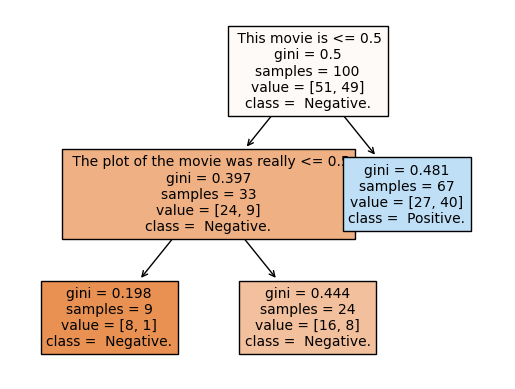

In [26]:
# visualize decision tree
plot_tree(
    m.clf_,
    fontsize=10,
    feature_names=m.feature_names_,
    class_names=list(verbalizer.values()),
    filled=True,
)
plt.show()